### Problem Statement ###

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.o reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

**Churn Phases**
- In ‘good’ phase the customer is happy with the service and behaves as usual
- In ‘action’ phase The customer experience starts to sore in this phase
- In ‘churn’ phase the customer is said to have churned

#### Business Goal ####

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

#### Outcomes ####

- Predict churn only on high-value customers
- Predict usage-based definition to define churn


### Step 1: Data Exploration

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:.2f}'.format)


plt.style.use('fivethirtyeight')

In [3]:
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [4]:
# Let's see the head of our master dataset
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [5]:
# Let's check the dimensions of the dataframe
telecom_df.shape

(99999, 226)

In [6]:
# let's look at the statistical aspects of the dataframe
telecom_df.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,99999.00,99999.00,98981.00,98981.00,98981.00,99999,99398,98899,98340,99999.00,99999.00,99999.00,99999.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.00,94621.00,92254.00,96062.00,96140.

In [7]:
# Let's see the type of each column
telecom_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [8]:
## Below columns are breaking the convention. So we will rename them appropriately
vbc_cols = [col for col in telecom_df.columns if 'vbc' in col]
print(vbc_cols)

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']


In [9]:
telecom_df.rename(columns = {'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

In [10]:
#DataType Correction 
object_df = telecom_df.select_dtypes(include='object')
object_df.head()

#Looks like all are datetime object

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [11]:
#convert object to date time

for col in object_df.columns:
    telecom_df[col] = pd.to_datetime(telecom_df[col])

In [12]:
telecom_df.shape

(99999, 226)

We are now ready to cleanse the data and create a Manageable Data Set for further processing

## Step 2 : Data Cleansing

**Common Utility Functions**

In [13]:
# Function which returns the columns with missing values > the cutoff percentage
# Argument: cutoff percentage between 1 - 100
def calculate_missing_values(data, cutoff):
    missing_percent= round(data.isna().sum() / len(data.index) * 100)
    print("{} features having more than {}% missing values:".format(len(missing_percent[missing_percent > cutoff]), cutoff))
    return missing_percent[missing_percent > cutoff]

#Function to handle missing values across months 
# Argument: Take list of column names without month number suffix 
def impute_zero_in_missing(data, columnList):
    for feature in [col + suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data[feature].fillna(0, inplace=True)
        

#Function to drop columns across months
def drop_columns(data,columnList):
    for feature in [col+suffix for suffix in ['_6','_7','_8','_9'] for col in columnList]:
        data.drop([feature],inplace=True, axis=1)

Drop columns which have only null values

In [14]:
telecom_df[telecom_df.isnull().all(axis=1)]

##Looks like there are no columns with only null values

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9


Drop all columns with 1 unique value 

In [15]:
unique_cols = telecom_df.nunique()
unique_cols[unique_cols == 1]

circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
last_date_of_month_7    1
last_date_of_month_8    1
last_date_of_month_9    1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_og_t2c_mou_9        1
std_ic_t2o_mou_6        1
std_ic_t2o_mou_7        1
std_ic_t2o_mou_8        1
std_ic_t2o_mou_9        1
dtype: int64

In [16]:
telecom_df.drop(unique_cols[unique_cols == 1].index, inplace=True, axis=1)

In [17]:
telecom_df.shape

(99999, 210)

Drop columns with missing values greater than 70% or impute the same

In [18]:
calculate_missing_values(telecom_df, 50)

40 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
total_rech_data_6          75.00
total_rech_data_7          74.00
total_rech_data_8          74.00
total_rech_data_9          74.00
max_rech_data_6            75.00
max_rech_data_7            74.00
max_rech_data_8            74.00
max_rech_data_9            74.00
count_rech_2g_6            75.00
count_rech_2g_7            74.00
count_rech_2g_8            74.00
count_rech_2g_9            74.00
count_rech_3g_6            75.00
count_rech_3g_7            74.00
count_rech_3g_8            74.00
count_rech_3g_9            74.00
av_rech_amt_data_6         75.00
av_rech_amt_data_7         74.00
av_rech_amt_data_8         74.00
av_rech_amt_data_9         74.00
arpu_3g_6                  75.00
arpu_3g_7                  74.00
arpu_3g_8                  74.00
arpu_3g_9                  74.00
arpu_2g_6                  75.00
arpu_2g_7                  74.00
arpu_2g_8 

Impute Missing Value as 0 for all the **Recharge, Revenue, Night Pack, Fb User** Fields

In [19]:
missingValueColumnList=['total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data'
                       , 'arpu_3g', 'arpu_2g', 'night_pck_user', 'fb_user']

In [20]:
# Since the minimum value is 1, we are going to handle NA values by imputing with 0 
# which means we are assuming there were no recharges done by the customer
impute_zero_in_missing(telecom_df, missingValueColumnList)

In [21]:
calculate_missing_values(telecom_df, 50)

4 features having more than 50% missing values:


date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_last_rech_data_9   74.00
dtype: float64

In [22]:
calculate_missing_values(telecom_df, 7)

31 features having more than 7% missing values:


onnet_mou_9                 8.00
offnet_mou_9                8.00
roam_ic_mou_9               8.00
roam_og_mou_9               8.00
loc_og_t2t_mou_9            8.00
loc_og_t2m_mou_9            8.00
loc_og_t2f_mou_9            8.00
loc_og_t2c_mou_9            8.00
loc_og_mou_9                8.00
std_og_t2t_mou_9            8.00
std_og_t2m_mou_9            8.00
std_og_t2f_mou_9            8.00
std_og_mou_9                8.00
isd_og_mou_9                8.00
spl_og_mou_9                8.00
og_others_9                 8.00
loc_ic_t2t_mou_9            8.00
loc_ic_t2m_mou_9            8.00
loc_ic_t2f_mou_9            8.00
loc_ic_mou_9                8.00
std_ic_t2t_mou_9            8.00
std_ic_t2m_mou_9            8.00
std_ic_t2f_mou_9            8.00
std_ic_mou_9                8.00
spl_ic_mou_9                8.00
isd_ic_mou_9                8.00
ic_others_9                 8.00
date_of_last_rech_data_6   75.00
date_of_last_rech_data_7   74.00
date_of_last_rech_data_8   74.00
date_of_la

We will drop all features which have more than 70% missing values

In [23]:
drop_columns(telecom_df,['date_of_last_rech_data'])

In [24]:
calculate_missing_values(telecom_df, 7)

27 features having more than 7% missing values:


onnet_mou_9        8.00
offnet_mou_9       8.00
roam_ic_mou_9      8.00
roam_og_mou_9      8.00
loc_og_t2t_mou_9   8.00
loc_og_t2m_mou_9   8.00
loc_og_t2f_mou_9   8.00
loc_og_t2c_mou_9   8.00
loc_og_mou_9       8.00
std_og_t2t_mou_9   8.00
std_og_t2m_mou_9   8.00
std_og_t2f_mou_9   8.00
std_og_mou_9       8.00
isd_og_mou_9       8.00
spl_og_mou_9       8.00
og_others_9        8.00
loc_ic_t2t_mou_9   8.00
loc_ic_t2m_mou_9   8.00
loc_ic_t2f_mou_9   8.00
loc_ic_mou_9       8.00
std_ic_t2t_mou_9   8.00
std_ic_t2m_mou_9   8.00
std_ic_t2f_mou_9   8.00
std_ic_mou_9       8.00
spl_ic_mou_9       8.00
isd_ic_mou_9       8.00
ic_others_9        8.00
dtype: float64

All columns except date columns are for the month 9 i.e the Churn phase. 
This data will be eventually dropped when we tag churn/no churn, 
hence we will be skipping imputing these fields related to month 9

### Step 3: Data Preparation ###

**Filter in High Value Customers which are the target of our analysis**

* A high-value customers is defined as follows:

- Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [26]:
# Create new column total recharge amount for data for aiding in finding High Value customer 

telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

In [27]:
#Create column for holding average of total recharge amount for good phase (the months June (6) and July (7))
# We add the total recharge amount of call and data and find the average across two months
telecom_df['total_avg_rech_amnt_Good_Phase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6 \
                                               + telecom_df.total_rech_amt_7+ telecom_df.total_rech_amt_data_7)/2

In [28]:
# filter values greater than 70th percentile of total average recharge amount for good phase 
seventieth_percentile = telecom_df.total_avg_rech_amnt_Good_Phase.quantile(0.7)

telecom_df_high_val_cust = telecom_df[telecom_df.total_avg_rech_amnt_Good_Phase > seventieth_percentile]

In [29]:
print("70th Percentile of Average Recharge amount in Good Phase (June and July month) is ", seventieth_percentile)

70th Percentile of Average Recharge amount in Good Phase (June and July month) is  478.0


In [30]:
telecom_df_high_val_cust.shape


(29953, 210)

**Define the Target Variable Churn based on the following criteria**

* A Churned Customer is defined as follows : 
* A Customer has churned (churn=1, else 0) if in the Ninth Month he/she has not made any calls (either incoming or outgoing) 
* AND have not used mobile internet even once. 



In [31]:
#Add a new column "churn", values would be either 1 (churn) or 0 (non-churn)
telecom_df_high_val_cust['churn'] = \
        np.where(telecom_df_high_val_cust[['total_ic_mou_9','total_og_mou_9', \
                                           'vol_2g_mb_9', 'vol_3g_mb_9']].sum(axis=1) == 0, 1,0)

0   0.92
1   0.08
Name: churn, dtype: float64


<AxesSubplot:>

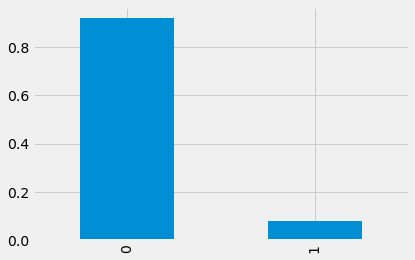

In [32]:
# Find out the % of churn/non churn customers
churn_percentage = telecom_df_high_val_cust.churn.value_counts(normalize=True)
print(churn_percentage)
churn_percentage.plot.bar()

**Observation** : The churn percentage is around 8%. This indicates that there is a slight imbalance in the dataset which will need to be corrected in modelling

**Drop all data of the ninth Month as that is our Target Variable**


In [33]:
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [34]:
churn_month_columns

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'total_rech_data_9',
       'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9',
       'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9',
       'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9'],

In [35]:
# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

In [36]:
# all Recharge related column list
recharge_columns = [col for col in telecom_df_high_val_cust if 'rech' in col.lower()]
recharge_columns

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8',
 'total_avg_rech_amnt_Good_Phase']

In [37]:
# all Date column list
date_columns = [col for col in telecom_df_high_val_cust if 'date' in col.lower()]
date_columns

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [38]:
#Getting the  day  columns
day_columns = [col for col in telecom_df_high_val_cust if 'day' in col.lower()]
day_columns

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

In [39]:
telecom_df_high_val_cust.shape

(29953, 160)

### Step 4 : EDA ### 

We will now perform EDA and try to get insights into the data. 
Based on the insights we could define our approach to training, remove outliers, remove highly correlated variables

**Drop Highly Correlated Columns as a PreRequisite to EDA**

In [40]:
## Creating a copy to avoid regenerating master for each iterations
##Check point 1
training_df = telecom_df_high_val_cust.copy()

<AxesSubplot:>

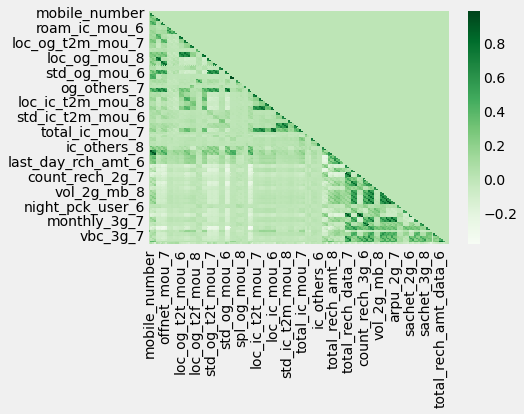

In [41]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False, )


Looks like there are strong multicollinearity issues, Lets drop data which is multi collinear

In [42]:
# Create correlation matrix
corr_matrix = training_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [43]:
training_df.drop(to_drop, axis =1, inplace=True)

In [44]:
training_df.shape

(29953, 132)

<AxesSubplot:>

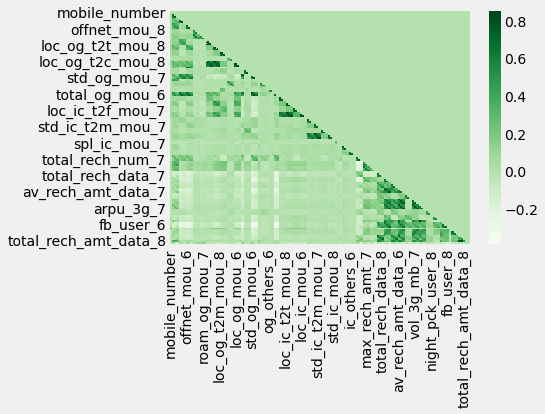

In [45]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = training_df.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
sns.heatmap(cor, cmap='Greens', annot=False)

In [46]:
#Checkpoint 2 
# We can run from checkpoints rather than run the entire notebook for validation
telecom_df_high_val_cust = training_df.copy()

In [47]:
# create box plot for  6th, 7th and 8th month
def create_box_plot(column):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=column+"_6",x="churn")
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=column+"_7",x="churn", showfliers=False)
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=column+"_8",x="churn", showfliers=False)
    plt.show()

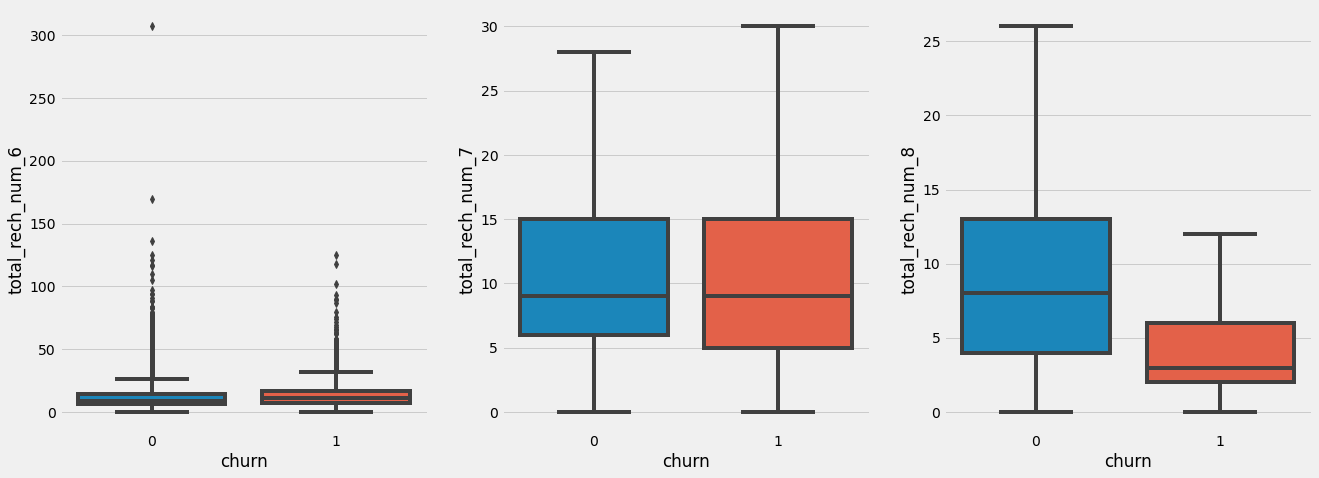

In [48]:
# Ploting for total recharge number:
create_box_plot('total_rech_num')

We can see that there is a huge drop in total recharge number for churned customers in the 8th month i.e action phase

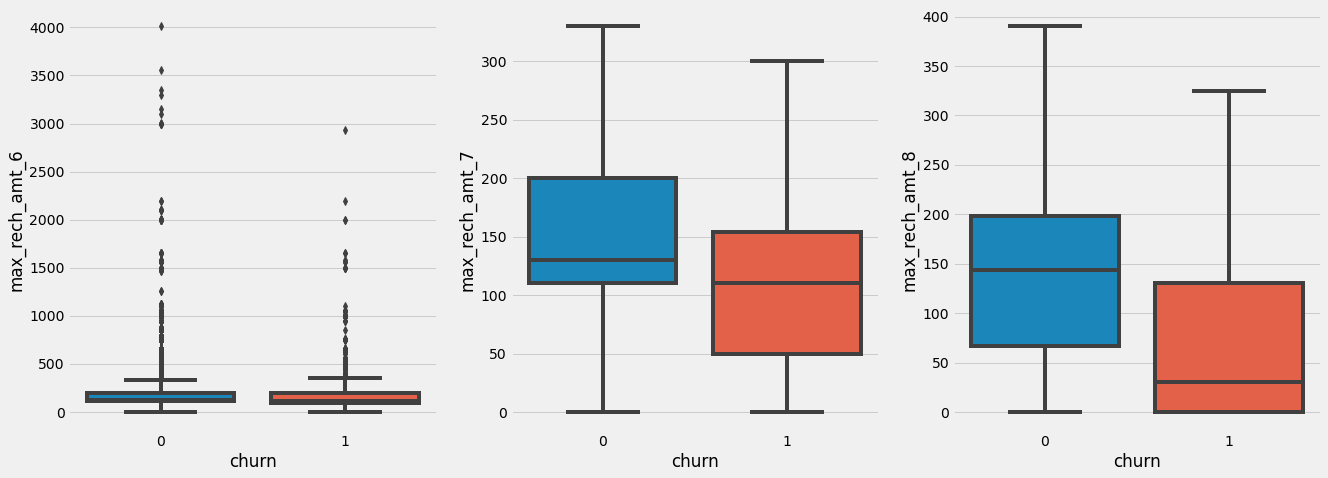

In [49]:
# Ploting for maximum recharge amount :
create_box_plot('max_rech_amt')

Again we can see that there is a huge drop in maximum recharge amount for churned customers in the 8th month i.e action phase


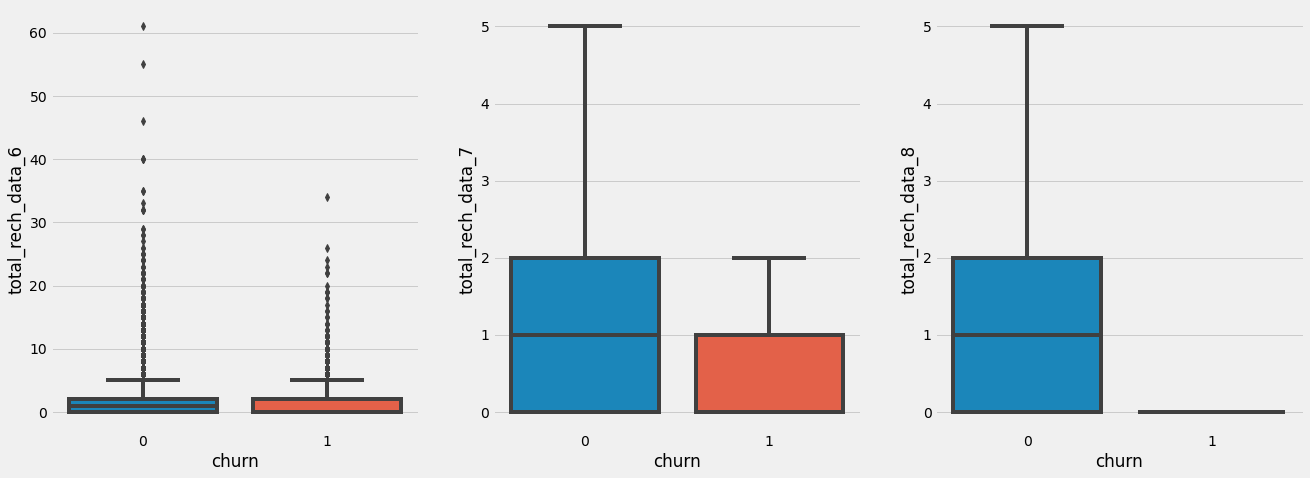

In [50]:
# Ploting for total recharge data:
create_box_plot('total_rech_data')

We can see a drop in the total recharge for data for churned customers in the 8th Month i.e Action Phase

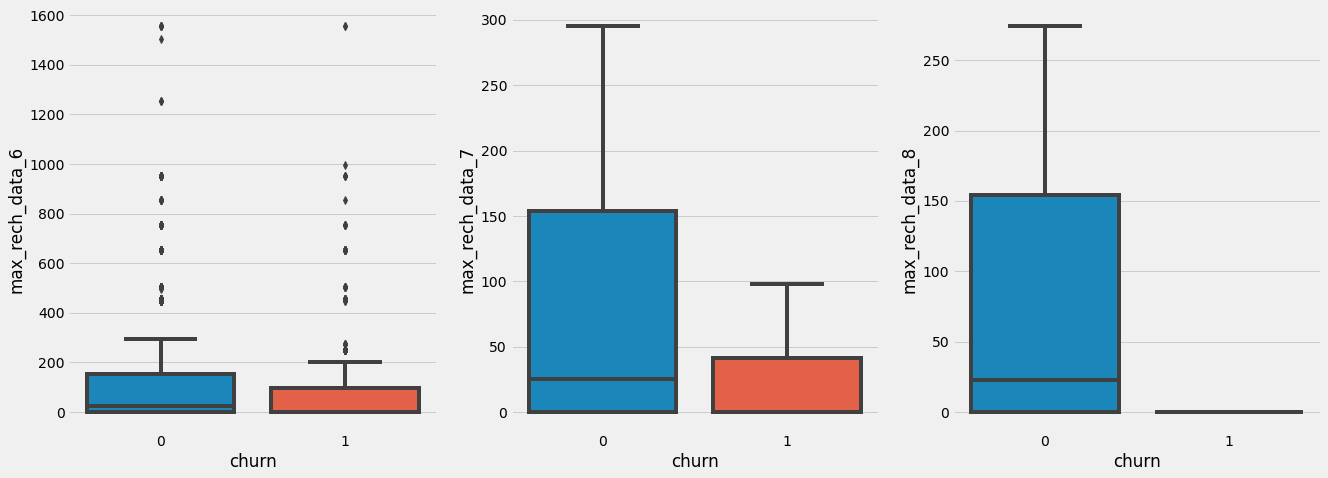

In [51]:
# Ploting for max recharge for data:
create_box_plot('max_rech_data')

There is a huge drop in max recharge amount data for churned customers in the 8th month i.e action phase 

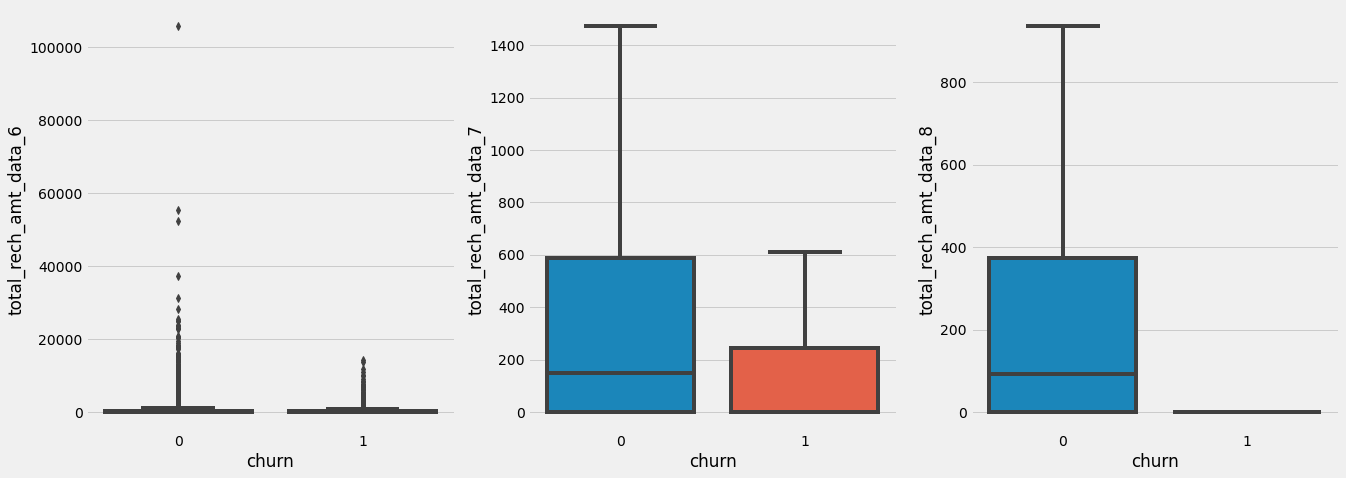

In [52]:
# Ploting for total recharge amount data :
create_box_plot('total_rech_amt_data')

Again we can see that there is a huge drop in total recharge amount data for churned customers in the 8th month i.e action phase

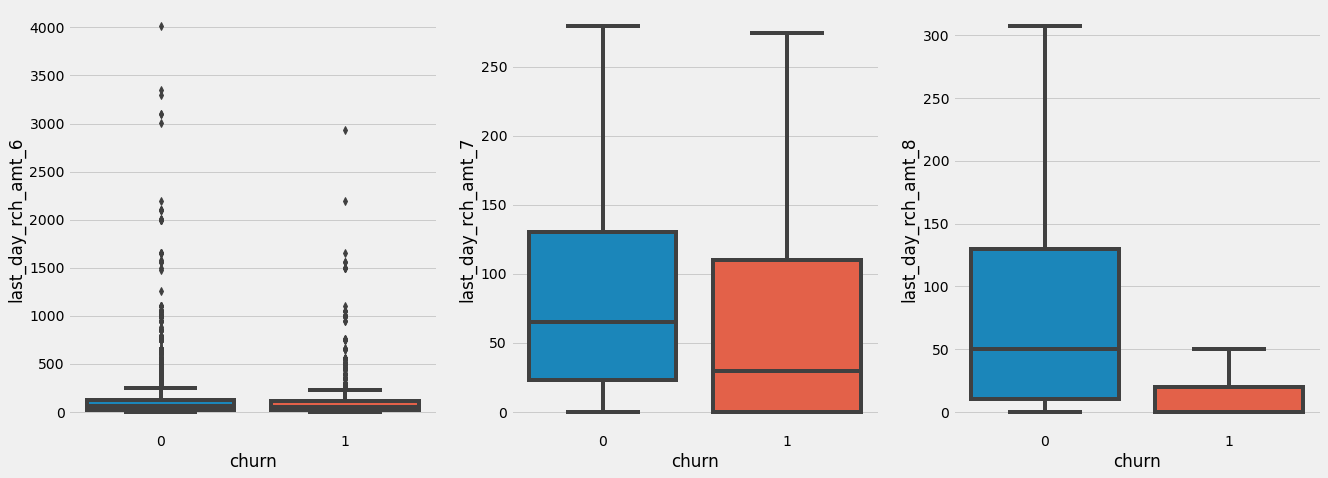

In [53]:
# Ploting for Last  day recharge amount  :
create_box_plot('last_day_rch_amt')

 We are seeing a huge drop in recharge amount for churned customers in the 8th month i.e Action phase 

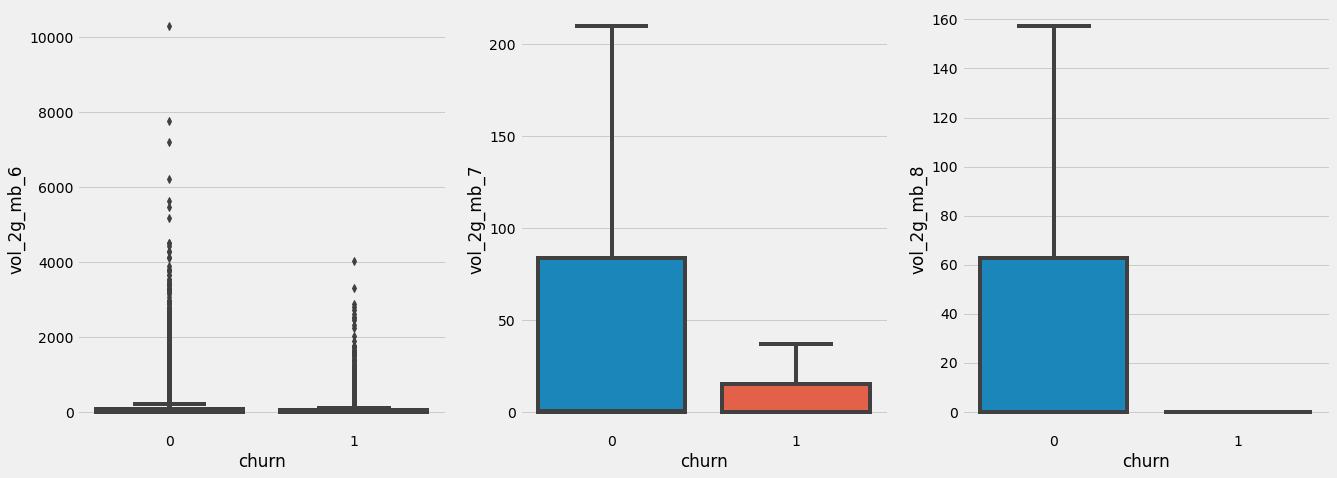

In [54]:
# Ploting for volume of 2G and 3G usage columns:
create_box_plot('vol_2g_mb')

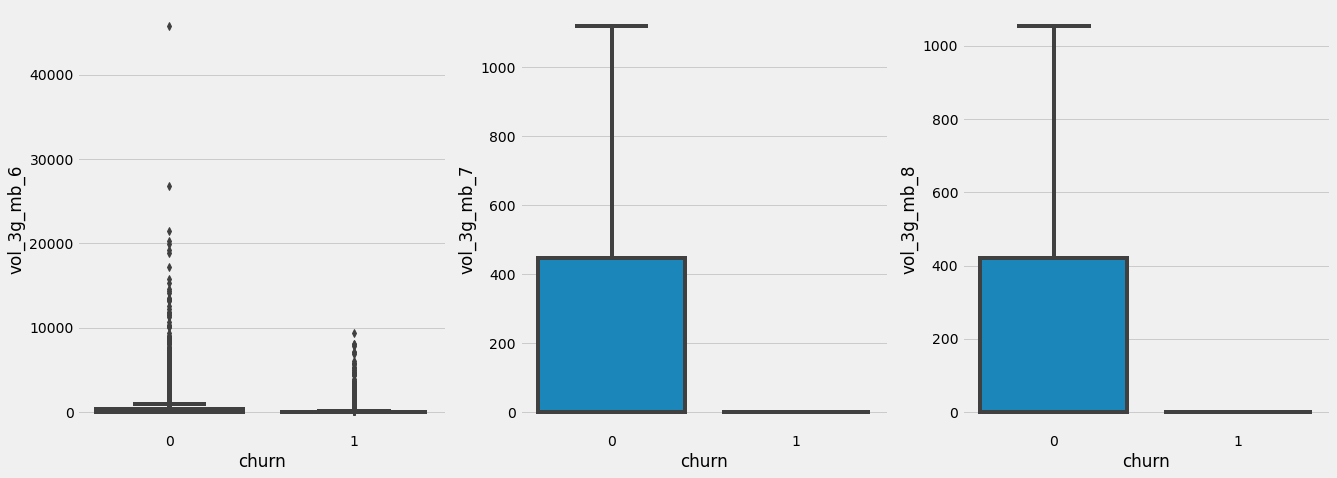

In [55]:
create_box_plot('vol_3g_mb')

We see 2g and 3g usage for churned customers drops in the 8th month i.e Action phase.

However in general we see the usage is low for churned customer across months. 